In [1]:
from scipy import spatial
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer

In [2]:
model_name = "all-MiniLM-L6-v2"
device = "cuda"
sbert_model = SentenceTransformer(model_name, device=device)

In [3]:
train_split = pd.read_csv("/home/evgenii/Desktop/ml_hw/NamePrompt/data/train_final.csv")
val_split = pd.read_csv("/home/evgenii/Desktop/ml_hw/NamePrompt/data/val_final.csv")


In [4]:
zeros = []
ones = []
for idx, row in tqdm(val_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    target = row["is_duplicate"]
    sentence_embeddings = sbert_model.encode(sentences)
    result = 1 - spatial.distance.cosine(*sentence_embeddings)
    if target == 0:
        zeros.append(result)
    else:
        ones.append(result)        

1558it [00:15, 99.51it/s] 


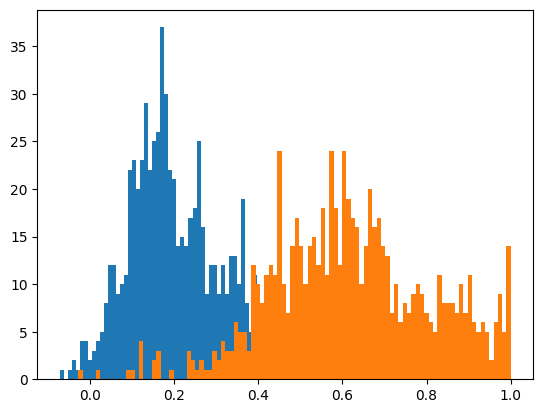

In [5]:
plt.hist(zeros, bins=100)
plt.hist(ones, bins=100)
plt.plot()
plt.show()

<h1>Train</h1>

In [4]:
sbert_model.train()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [5]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

train_examples = []
val_examples_0 = []
val_examples_1 = []
val_scores = []
train_drop = []
val_drop = []

for idx, row in tqdm(train_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    for sentence in sentences:
        if isinstance(sentence, float):
            print(idx)
            train_drop.append(idx)
    target = row["is_duplicate"]
    train_examples.append(InputExample(texts=sentences, label=float(target)))
    
for idx, row in tqdm(val_split.iterrows()):
    target = row["is_duplicate"]
    val_examples_0.append(row["name_1"])
    val_examples_1.append(row["name_2"])
    if isinstance(row["name_1"], float):
            print(idx, row["name_1"])
            val_drop.append(idx)
    if isinstance(row["name_2"], float):
            print(idx, row["name_2"])
            val_drop.append(idx)
    val_scores.append(float(target))

6228it [00:00, 18334.37it/s]
1558it [00:00, 16761.90it/s]


In [6]:
from sentence_transformers import evaluation
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_examples_0, val_examples_1, val_scores)

In [7]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
train_loss = losses.CosineSimilarityLoss(sbert_model)

sbert_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=50,
                output_path ="/home/evgenii/Desktop/ml_hw/NamePrompt/models",
                evaluator=evaluator, evaluation_steps=100, show_progress_bar=True)

Iteration:  13%|█████████████████▏                                                                                                                     | 99/779 [00:05<00:37, 17.90it/s]

Eval METRIC: 0.9565826330532213


Iteration:  26%|██████████████████████████████████▏                                                                                                   | 199/779 [00:12<00:31, 18.27it/s]

Eval METRIC: 0.9695712309820194


Iteration:  39%|███████████████████████████████████████████████████▌                                                                                  | 300/779 [00:21<02:21,  3.39it/s]

Eval METRIC: 0.9709543568464729


Iteration:  51%|████████████████████████████████████████████████████████████████████▊                                                                 | 400/779 [00:28<01:50,  3.43it/s]

Eval METRIC: 0.9752407152682256


Iteration:  64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 499/779 [00:34<00:14, 18.67it/s]

Eval METRIC: 0.9766162310866574


Iteration:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 602/779 [00:42<00:36,  4.79it/s]

Eval METRIC: 0.9737931034482759


Iteration:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 700/779 [00:49<00:23,  3.42it/s]

Eval METRIC: 0.9779917469050895


Epoch:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 1/2 [00:55<00:55, 55.55s/it]

Eval METRIC: 0.9779614325068869


Iteration:  13%|█████████████████▏                                                                                                                     | 99/779 [00:05<00:37, 18.03it/s]

Eval METRIC: 0.9786941580756013


Iteration:  25%|██████████████████████████████████                                                                                                    | 198/779 [00:12<00:30, 18.89it/s]

Eval METRIC: 0.9793956043956044


Iteration:  39%|████████████████████████████████████████████████████                                                                                  | 303/779 [00:21<01:39,  4.80it/s]

Eval METRIC: 0.9786941580756013


Iteration:  52%|█████████████████████████████████████████████████████████████████████▏                                                                | 402/779 [00:28<01:17,  4.87it/s]

Eval METRIC: 0.9793956043956044


Iteration:  65%|██████████████████████████████████████████████████████████████████████████████████████▌                                               | 503/779 [00:35<00:56,  4.86it/s]

Eval METRIC: 0.9793956043956044


Iteration:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████                               | 599/779 [00:40<00:09, 18.79it/s]

Eval METRIC: 0.9800687285223367


Iteration:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 702/779 [00:48<00:15,  5.03it/s]

Eval METRIC: 0.9800687285223367


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:50<00:00, 55.00s/it]

Eval METRIC: 0.9800687285223367


<h1>Metrics</h1>

In [12]:
sbert_model = SentenceTransformer("/home/evgenii/Desktop/ml_hw/NamePrompt/models/", device=device)

In [8]:
sbert_model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [9]:
zeros = []
ones = []
predicts = []
raw_predicts = []
for idx, row in tqdm(val_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    target = row["is_duplicate"]
    sentence_embeddings = sbert_model.encode(sentences)
    result = 1 - spatial.distance.cosine(*sentence_embeddings)
    if result > 0.5:
        label = 1
    else:
        label = 0
    predicts.append(label)
    raw_predicts.append(result)
    if target == 0:
        zeros.append(result)
    else:
        ones.append(result)    

1558it [00:13, 118.55it/s]


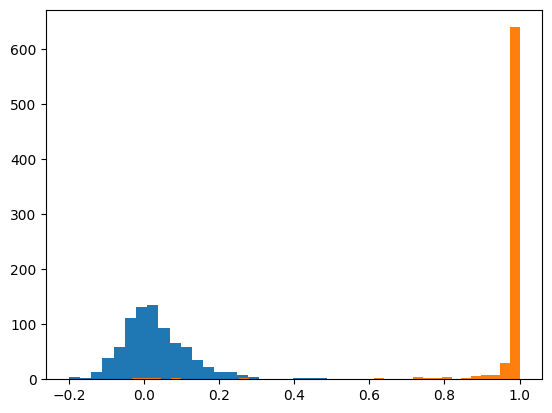

In [10]:
plt.hist(zeros, bins=40)
plt.hist(ones, bins=40)
plt.plot()
plt.show()

In [11]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay

In [12]:
round(f1_score(predicts, val_split["is_duplicate"].to_list()), 2)

0.98

In [13]:
round(precision_score(predicts, val_split["is_duplicate"].to_list()), 2)

0.97

In [14]:
round(recall_score(predicts, val_split["is_duplicate"].to_list()), 2)

0.99

In [15]:
round(roc_auc_score(val_split["is_duplicate"].to_list(), raw_predicts), 2)

0.99

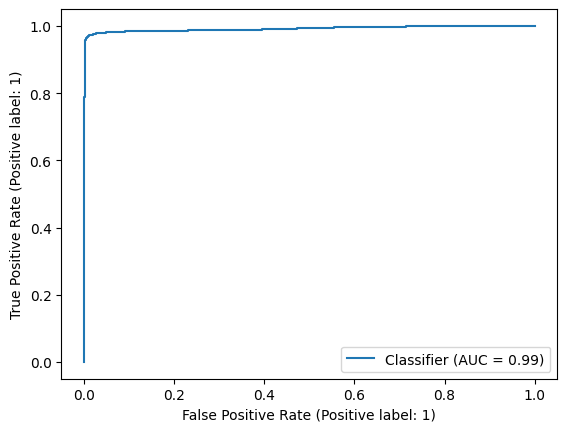

In [16]:
RocCurveDisplay.from_predictions(val_split["is_duplicate"].to_list(), raw_predicts)

<h1>Check Range</h1>

In [17]:
emb_dict = {}

In [34]:
def make_embedings(split):
    all_records = split.iloc[:, :2].values.flatten()
    embedings = []
    for record in tqdm(all_records):
        sentence_embedding = sbert_model.encode([record])[0]
        emb_dict[record] = sentence_embedding
make_embedings(val_split)
make_embedings(val_split)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3116/3116 [00:18<00:00, 167.99it/s]


In [35]:
def get_close_results(company, top_k=3):
    sentence_embedding = sbert_model.encode([company])[0]
    results = []
    for k,v in emb_dict.items():
        result = 1 - spatial.distance.cosine(v, sentence_embedding)
        results.append([k, result])
        
    output = pd.DataFrame(sorted(results,key=lambda x: x[1], reverse=True)[:top_k], columns=[["Name", "Score"]])
    return output

In [36]:
get_close_results("sika cambodia", top_k=3)

,Name,Score
0,sika cambodia .,0.998512
1,sika thailand,0.997048
2,sika cambodia . warehouse,0.996661


In [44]:
get_close_results("bridge", top_k=3)

,Name,Score
0,bridge chemical cv,0.975670
1,bridgestone group,0.794369
2,bridgestone ncr,0.788147


In [38]:
get_close_results("soup and salad", top_k=3)

,Name,Score
0,chowdhry,0.310351
1,kitchens industria comercio ltda,0.297995
2,holm cv,0.254664
